# Building your Recurrent Neural Network - Step by Step

Welcome to Course 5's first assignment! In this assignment, you will implement your first Recurrent Neural Network in numpy.

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have "memory". They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some information/context through the hidden layer activations that get passed from one time-step to the next. This allows a uni-directional RNN to take information from the past to process later inputs. A bidirection RNN can take context from both the past and the future. 

**Notation**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step. 
    - Example: $x^{\langle t \rangle}$ is the input x at the $t^{th}$ time-step. $x^{(i)\langle t \rangle}$ is the input at the $t^{th}$ timestep of example $i$.
    
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$.

We assume that you are already familiar with `numpy` and/or have completed the previous courses of the specialization. Let's get started!

Let's first import all the packages that you will need during this assignment.

In [12]:
import numpy as np
from rnn_utils import *
import matplotlib.pyplot as plt

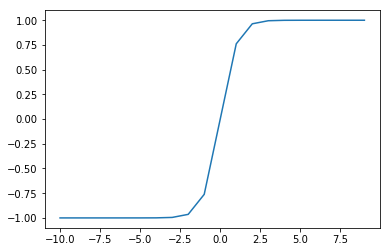

In [2]:
# tanh function refreshert
#tanh(x) = sinh(x)/cosh(x) = ( e^x - e^-x )/( e^x + e^-x )

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

x = np.arange(-10,10)
y = [tanh(i) for i in x]
plt.plot(x, y)
# plt.plot(x, np.tanh(x)) this does the exact same thing
plt.show()

In [4]:
# We will probably re-write these for practice in this notebook (AND FOR FUNSIES DUHHH!!!)
dir(rnn_utils)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'initialize_adam',
 'np',
 'rnn_forward',
 'sigmoid',
 'softmax',
 'update_parameters_with_adam']

## 1 - Forward propagation for the basic Recurrent Neural Network

Later this week, you will generate music using an RNN. The basic RNN that you will implement has the structure below. In this example, $T_x = T_y$. 

<img src="images/RNN.png" style="width:500;height:300px;">
<caption><center> **Figure 1**: Basic RNN model </center></caption>

Here's how you can implement an RNN: 

**Steps**:
1. Implement the calculations needed for one time-step of the RNN.
2. Implement a loop over $T_x$ time-steps in order to process all the inputs, one at a time. 

Let's go!

## 1.1 - RNN cell

A Recurrent neural network can be seen as the repetition of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 

<img src="images/rnn_step_forward.png" style="width:700px;height:300px;">
<caption><center> **Figure 2**: Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $y^{\langle t \rangle}$ </center></caption>

**Exercise**: Implement the RNN-cell described in Figure (2).

**Instructions**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. We provided you a function: `softmax`.
3. Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in cache
4. Return $a^{\langle t \rangle}$ , $y^{\langle t \rangle}$ and cache

We will vectorize over $m$ examples. Thus, $x^{\langle t \rangle}$ will have dimension $(n_x,m)$, and $a^{\langle t \rangle}$ will have dimension $(n_a,m)$. 

In [13]:
# GRADED FUNCTION: rnn_cell_forward

def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_feats, n_obs). Where:
        - n_feats number of features for each timestep of each sequence (observations)
        - n_obs is number of observations (OBSERVATIONS ARE ALONG COLUMNS... This removes need to transpose X or W)
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_hidden_neurons, n_obs)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_hidden_neurons, n_feats)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_hidden_neurons, n_hidden_neurons)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_out_neurons, n_hidden_neurons)
                        ba --  Bias, numpy array of shape (n_hidden_neurons, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_output_neurons, 1)
    Returns:
    a_next -- next hidden state, of shape (n_hidden_neurons, n_obs)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_out_neurons, n_obs)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # Extract params
    n_hidden_neurons = Wax.shape[0]
    n_output_neurons = Wya.shape[0]
    
    # Check param sizes
    assert Wax.shape[1] == xt.shape[0], "Wax cols must match Xt rows (num_feats)"
    assert Waa.shape[1] == a_prev.shape[0], "Waa cols must match a_prev rows (n_hidden_neurons)"
    assert ba.shape[0] == n_hidden_neurons, "ba rows must match n_hidden_neurons"
    assert by.shape[0] == n_output_neurons, "by rows must match n_output_neurons"    
    
    ### START CODE HERE ### (≈2 lines)
    # compute next activatio`bn state using the formula given above
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    ### END CODE HERE ###
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [14]:
np.random.seed(1)

# SET INPUT PARAMS
n_feats = 3
n_obs = 10
n_timesteps = 4
n_hidden_neurons = 5
n_out_neurons = 2

# SET MODEL INPUTS
xt = np.random.randn(n_feats,n_obs)
a_prev = np.random.randn(n_hidden_neurons,n_obs)
parameters = {"Waa": np.random.randn(n_hidden_neurons, n_hidden_neurons),
              "Wax": np.random.randn(n_hidden_neurons,n_feats),
              "Wya": np.random.randn(n_out_neurons, n_hidden_neurons),
              "ba": np.random.randn(n_hidden_neurons,1),
              "by": np.random.randn(n_out_neurons,1)}


# Join all variables into params dictionary
#parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)
print("Wax shape: ", parameters["Wax"].shape, " Xt shape:", xt.shape, )
print("Waa shape: ", parameters["Waa"].shape, " a_prev shape: ", a_prev.shape, )
print("Wya: ", parameters["Wya"].shape, " a_next shape: ", a_next.shape, )
print()
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

Wax shape:  (5, 3)  Xt shape: (3, 10)
Waa shape:  (5, 5)  a_prev shape:  (5, 10)
Wya:  (2, 5)  a_next shape:  (5, 10)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


**Expected Output**: 

<table>
    <tr>
        <td>
            **a_next[4]**:
        </td>
        <td>
           [ 0.59584544,   0.18141802,   0.61311866,   0.99808218,   0.85016201,   0.99980978,
 -0.18887155,   0.99815551,   0.6531151,    0.82872037]
        </td>
    </tr>
        <tr>
        <td>
            **a_next.shape**:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **yt[1]**:
        </td>
        <td>
           [ 0.9888161   0.01682021  0.21140899  0.36817467  0.98988387  0.88945212
  0.36920224  0.9966312   0.9982559   0.17746526]
        </td>
    </tr>
        <tr>
        <td>
            **yt.shape**:
        </td>
        <td>
           (2, 10)
        </td>
    </tr>

</table>

## 1.2 - RNN forward pass 

You can see an RNN as the repetition of the cell you've just built. If your input sequence of data is carried over 10 time steps, then you will copy the RNN cell 10 times. Each cell takes as input the hidden state from the previous cell ($a^{\langle t-1 \rangle}$) and the current time-step's input data ($x^{\langle t \rangle}$). It outputs a hidden state ($a^{\langle t \rangle}$) and a prediction ($y^{\langle t \rangle}$) for this time-step.


<img src="images/rnn1.png" style="width:800px;height:300px;">
<caption><center> **Figure 3**: Basic RNN. The input sequence $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$  is carried over $T_x$ time steps. The network outputs $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$. </center></caption>



**Exercise**: Code the forward propagation of the RNN described in Figure (3).

**Instructions**:
1. Create a vector of zeros ($a$) that will store all the hidden states computed by the RNN.
2. Initialize the "next" hidden state as $a_0$ (initial hidden state).
3. Start looping over each time step, your incremental index is $t$ :
    - Update the "next" hidden state and the cache by running `rnn_cell_forward`
    - Store the "next" hidden state in $a$ ($t^{th}$ position) 
    - Store the prediction in y
    - Add the cache to the list of caches
4. Return $a$, $y$ and caches

In [21]:
# GRADED FUNCTION: rnn_forward

def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_feats, n_obs, n_timesteps). 
    a0 -- Initial hidden state, of shape (n_hidden_neurons, n_obs) 
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_hidden_neurons, n_hidden_neurons)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_hidden_neurons, n_feats)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_out_neurons, n_hidden_neurons)
                        ba --  Bias numpy array of shape (n_hidden_neurons, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_out_neurons, 1)

    Returns:
    hidden_states -- Hidden states for every time-step, numpy array of shape (n_hidden_neurons, n_obs, n_timesteps)
    y_preds -- Predictions for every time-step, numpy array of shape (n_out_neurons, n_obs, n_timesteps)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and Wy
    n_feats, n_obs, n_timesteps = x.shape
    n_out_neurons, n_hidden_neurons = parameters["Wya"].shape
    
    ### START CODE HERE ###
    
    # initialize "a" (hidden states) and "y" (y_pred) with zeros (≈2 lines)
    hidden_states = np.zeros((n_hidden_neurons, n_obs, n_timesteps))
    y_preds = np.zeros((n_out_neurons, n_obs, n_timesteps))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(n_timesteps):
        # Update next hidden state, compute the prediction, get the cache (≈1 line)
        # Use only t of x (third dimension of x)...
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        hidden_states[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y_preds[:,:,t] = yt_pred
        # Append "cache" to "caches" (≈1 line)
        caches.append(cache)
        
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return hidden_states, y_preds, caches

In [24]:
np.random.seed(1)

# SET INPUT PARAMS
n_feats = 3
n_obs = 10
n_timesteps = 4
n_hidden_neurons = 5
n_out_neurons = 2

# SET MODEL INPUTS
x = np.random.randn(n_feats,n_obs,n_timesteps)
a0 = np.random.randn(n_hidden_neurons,n_obs)

# REMEMBER: THESE WONT CHANGE AT ALL IN THE FEEDFORWARD, WE ARE JUST DOING PREDICTION!!!
parameters = {"Waa": np.random.randn(n_hidden_neurons, n_hidden_neurons),
              "Wax": np.random.randn(n_hidden_neurons,n_feats),
              "Wya": np.random.randn(n_out_neurons, n_hidden_neurons),
              "ba": np.random.randn(n_hidden_neurons,1),
              "by": np.random.randn(n_out_neurons,1)}

# Run feedforward mdoel
a, y_pred, caches = rnn_forward(x, a0, parameters)

print("X shape (3 features for each of 10 sequences (observtions), each has 4 timesteps):  ", x.shape)
print("Wax shape: ", parameters['Wax'].shape, " Xt1 shape:", x[:,:,0].shape, )
print("Waa shape: ", parameters['Waa'].shape, " a0 shape: ", a0.shape, )
print("Wya: ", parameters['Wya'].shape, " a_next shape: ", a_next.shape, )
print()
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

X shape (3 features for each of 10 sequences (observtions), each has 4 timesteps):   (3, 10, 4)
Wax shape:  (5, 3)  Xt1 shape: (3, 10)
Waa shape:  (5, 5)  a0 shape:  (5, 10)
Wya:  (2, 5)  a_next shape:  (5, 10)

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


**Expected Output**:

<table>
    <tr>
        <td>
            **a[4][1]**:
        </td>
        <td>
           [-0.99999375  0.77911235 -0.99861469 -0.99833267]
        </td>
    </tr>
        <tr>
        <td>
            **a.shape**:
        </td>
        <td>
           (5, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **y[1][3]**:
        </td>
        <td>
           [ 0.79560373  0.86224861  0.11118257  0.81515947]
        </td>
    </tr>
        <tr>
        <td>
            **y.shape**:
        </td>
        <td>
           (2, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **cache[1][1][3]**:
        </td>
        <td>
           [-1.1425182  -0.34934272 -0.20889423  0.58662319]
        </td>
    </tr>
        <tr>
        <td>
            **len(cache)**:
        </td>
        <td>
           2
        </td>
    </tr>

</table>

Congratulations! You've successfully built the forward propagation of a recurrent neural network from scratch. This will work well enough for some applications, but it suffers from vanishing gradient problems. So it works best when each output $y^{\langle t \rangle}$ can be estimated using mainly "local" context (meaning information from inputs $x^{\langle t' \rangle}$ where $t'$ is not too far from $t$). 

In the next part, you will build a more complex LSTM model, which is better at addressing vanishing gradients. The LSTM will be better able to remember a piece of information and keep it saved for many timesteps. 

## 2 - Long Short-Term Memory (LSTM) network

This following figure shows the operations of an LSTM-cell.

<img src="images/LSTM.png" style="width:500;height:400px;">
<caption><center> **Figure 4**: LSTM-cell. This tracks and updates a "cell state" or memory variable $c^{\langle t \rangle}$ at every time-step, which can be different from $a^{\langle t \rangle}$. </center></caption>

Similar to the RNN example above, you will start by implementing the LSTM cell for a single time-step. Then you can iteratively call it from inside a for-loop to have it process an input with $T_x$ time-steps. 

### About the gates

#### - Forget gate

For the sake of this illustration, lets assume we are reading words in a piece of text, and want use an LSTM to keep track of grammatical structures, such as whether the subject is singular or plural. If the subject changes from a singular word to a plural word, we need to find a way to get rid of our previously stored memory value of the singular/plural state. In an LSTM, the forget gate lets us do this: 

$$\Gamma_f^{\langle t \rangle} = \sigma(W_f[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_f)\tag{1} $$

Here, $W_f$ are weights that govern the forget gate's behavior. We concatenate $[a^{\langle t-1 \rangle}, x^{\langle t \rangle}]$ and multiply by $W_f$. The equation above results in a vector $\Gamma_f^{\langle t \rangle}$ with values between 0 and 1. This forget gate vector will be multiplied element-wise by the previous cell state $c^{\langle t-1 \rangle}$. So if one of the values of $\Gamma_f^{\langle t \rangle}$ is 0 (or close to 0) then it means that the LSTM should remove that piece of information (e.g. the singular subject) in the corresponding component of $c^{\langle t-1 \rangle}$. If one of the values is 1, then it will keep the information. 

#### - Update gate

Once we forget that the subject being discussed is singular, we need to find a way to update it to reflect that the new subject is now plural. Here is the formulat for the update gate: 

$$\Gamma_u^{\langle t \rangle} = \sigma(W_u[a^{\langle t-1 \rangle}, x^{\{t\}}] + b_u)\tag{2} $$ 

Similar to the forget gate, here $\Gamma_u^{\langle t \rangle}$ is again a vector of values between 0 and 1. This will be multiplied element-wise with $\tilde{c}^{\langle t \rangle}$, in order to compute $c^{\langle t \rangle}$.

#### - Updating the cell 

To update the new subject we need to create a new vector of numbers that we can add to our previous cell state. The equation we use is: 

$$ \tilde{c}^{\langle t \rangle} = \tanh(W_c[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_c)\tag{3} $$

Finally, the new cell state is: 

$$ c^{\langle t \rangle} = \Gamma_f^{\langle t \rangle}* c^{\langle t-1 \rangle} + \Gamma_u^{\langle t \rangle} *\tilde{c}^{\langle t \rangle} \tag{4} $$


#### - Output gate

To decide which outputs we will use, we will use the following two formulas: 

$$ \Gamma_o^{\langle t \rangle}=  \sigma(W_o[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_o)\tag{5}$$ 
$$ a^{\langle t \rangle} = \Gamma_o^{\langle t \rangle}* \tanh(c^{\langle t \rangle})\tag{6} $$

Where in equation 5 you decide what to output using a sigmoid function and in equation 6 you multiply that by the $\tanh$ of the previous state. 

### 2.1 - LSTM cell

**Exercise**: Implement the LSTM cell described in the Figure (3).

**Instructions**:
1. Concatenate $a^{\langle t-1 \rangle}$ and $x^{\langle t \rangle}$ in a single matrix: $concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$
2. Compute all the formulas 1-6. You can use `sigmoid()` (provided) and `np.tanh()`.
3. Compute the prediction $y^{\langle t \rangle}$. You can use `softmax()` (provided).

<img src="images/LSTM.png" style="width:500;height:400px;">


# Note that we concatenate the weights here, but the raw equations look like this... We will use the equation with the red star next to it (the forget gate calc) to demonstrate that both methods produce the same results!
![](images/homl_ch14_LSTM.jpg)
![](images/InkedInkedhoml_ch14_LSTMeq_LI2.jpg)


- Wxi, Wxf, Wxo, Wxg are the weight matrices of each of the four layers for their connection to the input vector x(t).
- Whi, Whf, Who, and Whg are the weight matrices of each of the four layers for their connection to the previous short-term state h(t–1).
- bi, bf, bo, and bg are the bias terms for each of the four layers. Note that TensorFlow initializes bf to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.
- **NOTE: In this version, we have no Wy weights... but we will build them into our model**

In [15]:
n_feats = 3
n_obs = 10
n_hidden = 5

# first half of equation
Wxf = np.random.randn(n_hidden, n_feats)
xt = np.random.randn(n_feats,n_obs)

# second half of equation
Whf = np.random.randn(n_hidden, n_hidden)
ht1 = np.random.randn(n_hidden,n_obs)

# Forget gate calc1:
forget_gate1 = np.dot(Wxf, xt) + np.dot(Whf, ht1)
print("fg1 shape:", forget_gate1.shape)

# Forget gate calc2:
Wf = np.hstack([Wxf, Whf])
concat = np.vstack([xt, ht1])
forget_gate2 = np.dot(Wf, concat)
print("fg2 shape:", forget_gate2.shape)

# ARE THEY EQUAL?!?
print("Are they equal?: \n",np.round(forget_gate1,3) == np.round(forget_gate2,3))

fg1 shape: (5, 10)
fg2 shape: (5, 10)
Are they equal?: 
 [[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


# NEAT! THEY MATCH!!!
- UPDATE GATE: Wxi & Whi -> Wi (or Wu, which is what I call it here because it is the UPDATE weight matrix)
- FORGET GATE: Wxf & Whf -> Wf
- OUTPUT GATE: Wxo & Who -> Wo
- C GATE: Wxg & Whh -> Wg (this is used to calc the temporary C(t) value (C tilde)

The Wg is usued to calc the temporary C value (or C tilde). This value is then multiplied element wise by the update gate, the product of which is added to the element wise product of the forget gate and the old C(t-1). This gets you the new C value!!! It seems confusing, but if you follow the equations its actually quite clear. 

### Great, now lets build a LSTM model! 

In [17]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_feats, n_obs).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_hidden_neurons, n_obs)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_hidden_neurons, n_obs)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_hidden_neurons, n_hidden_neurons + n_feats)
                        bf -- Bias of the forget gate, numpy array of shape (n_hidden_neurons, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_hidden_neurons, n_hidden_neurons + n_feats)
                        bi -- Bias of the update gate, numpy array of shape (n_hidden_neurons, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_hidden_neurons, n_hidden_neurons + n_feats)
                        bc -- Bias of the first "tanh", numpy array of shape (n_hidden_neurons, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_hidden_neurons, n_hidden_neurons + n_feats)
                        bo -- Bias of the output gate, numpy array of shape (n_hidden_neurons, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_output_neurons, n_hidden_neurons)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_output_neurons, 1)
    Returns:
    a_next -- next hidden state, of shape (n_hidden_neurons, n_obs)
    c_next -- next memory state, of shape (n_hidden_neurons, n_obs)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_output_neurons, n_obs)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the memory value
    """

    # Retrieve parameters from "parameters"
    W_forget = parameters["Wf"]
    W_update = parameters["Wi"]
    W_output = parameters["Wo"]
    W_c = parameters["Wc"]
    W_y = parameters["Wy"]

    b_forget = parameters["bf"]
    b_update= parameters["bi"]
    b_output = parameters["bo"]
    b_c = parameters["bc"]
    b_y = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_feats, n_obs = xt.shape
    n_output_neurons, n_hidden_neurons = W_y.shape

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈3 lines)
    #concat = np.zeros((n_hidden_neurons + n_feats, n_obs))
    #concat[: n_hidden_neurons, :] = a_prev 
    #concat[n_hidden_neurons :, :] = xt
    # LETS DO IT ONE LINE OF CODE!
    concat = np.vstack([a_prev,xt])

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    # REMEMBER: We use stacking here to shorten and speed up the code
    # [(Waf*a(t-1)) + (Wxf*x(t))] == hstack(Waf,Wxf) * vstack(a(t-1),x(t)) 

    # CALCULATE GATES (np.dot(weights,concat))
    forget_gate = sigmoid(np.dot(W_forget, concat) + b_forget)
    update_gate = sigmoid(np.dot(W_update, concat) + b_update)
    output_gate = sigmoid(np.dot(W_output, concat) + b_output)
    
    # CALCULATE CANDIDATE C VALUE
    c_candidate = np.tanh(np.dot(W_c, concat) + b_c)
    
    # CALCULATE OUTPUTS
    c_next = forget_gate * c_prev + update_gate * c_candidate
    a_next = output_gate * np.tanh(c_next)
    yt_pred = softmax(np.dot(W_y, a_next) + b_y)
    
    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, forget_gate, update_gate, c_candidate, output_gate, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [18]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("Showing first and last 2 elements of each list:\n")
print("a_next[4] = ", a_next[4][[0,1,-2,-1,]])
print("a_next.shape = ", a_next.shape,"\n")
print("c_next[2] = ", c_next[2][[0,1,-2,-1,]])
print("c_next.shape = ", c_next.shape,"\n")
print("yt[1] =", yt[1][[0,1,-2,-1,]])
print("yt.shape = ", yt.shape,"\n")
print("cache[1][3] =", cache[1][3][[0,1,-2,-1,]])
print("len(cache) = ", len(cache))

Showing first and last 2 elements of each list:

a_next[4] =  [-0.66408471  0.0036921  -0.00215674  0.43827275]
a_next.shape =  (5, 10) 

c_next[2] =  [ 0.63267805  1.00570849 -0.74348425 -0.26810932]
c_next.shape =  (5, 10) 

yt[1] = [0.79913913 0.15986619 0.39380172 0.07828381]
yt.shape =  (2, 10) 

cache[1][3] = [-0.16263996  1.03729328  1.41219977 -0.37647422]
len(cache) =  10


**Expected Output**:

<table>
    <tr>
        <td>
            **a_next[4]**:
        </td>
        <td>
           [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
        </td>
    </tr>
        <tr>
        <td>
            **a_next.shape**:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **c_next[2]**:
        </td>
        <td>
           [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
        </td>
    </tr>
        <tr>
        <td>
            **c_next.shape**:
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **yt[1]**:
        </td>
        <td>
           [ 0.79913913  0.15986619  0.22412122  0.15606108  0.97057211  0.31146381
  0.00943007  0.12666353  0.39380172  0.07828381]
        </td>
    </tr>
        <tr>
        <td>
            **yt.shape**:
        </td>
        <td>
           (2, 10)
        </td>
    </tr>
    <tr>
        <td>
            **cache[1][3]**:
        </td>
        <td>
           [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
        </td>
    </tr>
        <tr>
        <td>
            **len(cache)**:
        </td>
        <td>
           10
        </td>
    </tr>

</table>

### 2.2 - Forward pass for LSTM

Now that you have implemented one step of an LSTM, you can now iterate this over this using a for-loop to process a sequence of $T_x$ inputs. 

<img src="images/LSTM_rnn.png" style="width:500;height:300px;">
<caption><center> **Figure 4**: LSTM over multiple time-steps. </center></caption>

**Exercise:** Implement `lstm_forward()` to run an LSTM over $T_x$ time-steps. 

**Note**: $c^{\langle 0 \rangle}$ is initialized with zeros.

In [19]:
# GRADED FUNCTION: lstm_forward
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START CODE HERE ###
    # Retrieve dimensions from shapes of x and Wy (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros((n_a, m, T_x))
    c = np.zeros((n_a, m, T_x))
    y = np.zeros((n_y, m, T_x))
    
    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros(a_next.shape)
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y[:,:,t] = yt
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
        
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [20]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters1 = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters1)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape,"\n")
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape,"\n")
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1],"\n")
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7) 

y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7) 

caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981 

len(caches) =  2


**Expected Output**:

<table>
    <tr>
        <td>
            **a[4][3][6]** =
        </td>
        <td>
           0.172117767533
        </td>
    </tr>
        <tr>
        <td>
            **a.shape** =
        </td>
        <td>
           (5, 10, 7)
        </td>
    </tr>
        <tr>
        <td>
            **y[1][4][3]** =
        </td>
        <td>
           0.95087346185
        </td>
    </tr>
        <tr>
        <td>
            **y.shape** =
        </td>
        <td>
           (2, 10, 7)
        </td>
    </tr>
        <tr>
        <td>
            **caches[1][1][1]** =
        </td>
        <td>
           [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
        </td>
        
     </tr>
        <tr>
        <td>
            **c[1][2][1]** =
        </td>
        <td>
           -0.855544916718
        </td>
    </tr>       
        
    </tr>
        <tr>
        <td>
            **len(caches)** =
        </td>
        <td>
           2
        </td>
    </tr>

</table>

In [21]:
# GRADED FUNCTION: lstm_forward
def lstm_forward2(x, n_hidden_neurons=5, n_output_neurons=2):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """
    
    ###### EXTRACT X SHAPE ######
    n_feats, n_obs, n_timesteps = x.shape
    a0 = np.random.randn(n_hidden_neurons, n_obs)
    
    ###### INITIALIZE WEIGHTS AND BIAS TERMS ######
    W_forget = np.random.randn(n_hidden_neurons, n_hidden_neurons+n_feats)
    b_forget = np.random.randn(n_hidden_neurons, 1)

    W_update = np.random.randn(n_hidden_neurons, n_hidden_neurons+n_feats)
    b_update= np.random.randn(n_hidden_neurons, 1)

    W_output = np.random.randn(n_hidden_neurons, n_hidden_neurons+n_feats)
    b_output = np.random.randn(n_hidden_neurons, 1)

    W_candidate = np.random.randn(n_hidden_neurons, n_hidden_neurons+n_feats)
    b_candidate = np.random.randn(n_hidden_neurons, 1)

    W_predict = np.random.randn(n_output_neurons, n_hidden_neurons) # No stacking needed here!!!
    b_predict = np.random.randn(n_output_neurons, 1)
    
    parameters = {"Wf": W_forget, "Wi": W_update, "Wo": W_output, "Wc": W_candidate, "Wy": W_predict,
                  "bf": b_forget, "bi": b_update, "bo": b_output, "bc": b_candidate, "by": b_predict}

    ###### INITIALIZE "caches", WHICH TRACKS LIST OF ALL CLACHES ######
    caches = []
    
    ###### INIITIALIZE EMPTY a, c, and y VALUES ######
    a = np.zeros((n_hidden_neurons, n_obs, n_timesteps))
    c = np.zeros((n_hidden_neurons, n_obs, n_timesteps))
    y = np.zeros((n_output_neurons, n_obs, n_timesteps))
    
    ###### INITIALIZE a_next AND c_next ######
    a_next = a0
    c_next = np.zeros(a_next.shape)
    
    ###### LOOP OVER EACH TIMESTEP ######
    for t in range(n_timesteps):
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a
        a[:,:,t] = a_next
        # Save the value of the prediction in y
        y[:,:,t] = yt
        # Save the value of the next cell state in c
        c[:,:,t]  = c_next
        # Append the cache into caches
        caches.append(cache)
    
    # STORE VALUES NEEDED FOR BACKPROP
    caches = (caches, x)
    return a, y, c, caches, parameters

In [22]:
np.random.seed(1)
x = np.random.randn(3,10,7)

a, y, c, caches, parameters2 = lstm_forward2(x, n_hidden_neurons=5, n_output_neurons=2)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape,"\n")
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape,"\n")
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1],"\n")
print("len(caches) = ", len(caches))

a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7) 

y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7) 

caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981 

len(caches) =  2


**Expected Output**:

<table>
    <tr>
        <td>
            **a[4][3][6]** =
        </td>
        <td>
           0.172117767533
        </td>
    </tr>
        <tr>
        <td>
            **a.shape** =
        </td>
        <td>
           (5, 10, 7)
        </td>
    </tr>
        <tr>
        <td>
            **y[1][4][3]** =
        </td>
        <td>
           0.95087346185
        </td>
    </tr>
        <tr>
        <td>
            **y.shape** =
        </td>
        <td>
           (2, 10, 7)
        </td>
    </tr>
        <tr>
        <td>
            **caches[1][1][1]** =
        </td>
        <td>
           [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
        </td>
        
     </tr>
        <tr>
        <td>
            **c[1][2][1]** =
        </td>
        <td>
           -0.855544916718
        </td>
    </tr>       
        
    </tr>
        <tr>
        <td>
            **len(caches)** =
        </td>
        <td>
           2
        </td>
    </tr>

</table>

Congratulations! You have now implemented the forward passes for the basic RNN and the LSTM. When using a deep learning framework, implementing the forward pass is sufficient to build systems that achieve great performance. 

The rest of this notebook is optional, and will not be graded.

## 3 - Backpropagation in recurrent neural networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers do not need to bother with the details of the backward pass. If however you are an expert in calculus and want to see the details of backprop in RNNs, you can work through this optional portion of the notebook. 

When in an earlier course you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in recurrent neural networks you can to calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are quite complicated and we did not derive them in lecture. However, we will briefly present them below. 

### 3.1 - Basic RNN  backward pass

We will start by computing the backward pass for the basic RNN-cell.

<img src="images/rnn_cell_backprop.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 5**: RNN-cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the RNN by following the chain-rule from calculus. The chain-rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. </center></caption>

#### Deriving the one step backward functions: 

To compute the `rnn_cell_backward` you need to compute the following equations. It is a good exercise to derive them by hand. 

The derivative of $\tanh$ is $1-\tanh(x)^2$. You can find the complete proof [here](https://www.wyzant.com/resources/lessons/math/calculus/derivative_proofs/tanx). Note that: $ \sec(x)^2 = 1 - \tanh(x)^2$

Similarly for $\frac{ \partial a^{\langle t \rangle} } {\partial W_{ax}}, \frac{ \partial a^{\langle t \rangle} } {\partial W_{aa}},  \frac{ \partial a^{\langle t \rangle} } {\partial b}$, the derivative of  $\tanh(u)$ is $(1-\tanh(u)^2)du$. 
    - Where u is a_next
    - and du is the derivative of a_next

The final two equations also follow same rule and are derived using the $\tanh$ derivative. Note that the arrangement is done in a way to get the same dimensions to match.

In [95]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START CODE HERE ###
    # compute the gradient of tanh with respect to a_next (≈1 line)
    # a_next = 
    # (1 - tang(Wx*x))
    dtanh = (1 - a_next ** 2) * da_next

    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = np.dot(Wax.T, dtanh) 
    dWax = np.dot(dtanh, xt.T)

    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = np.dot(Waa.T, dtanh)
    dWaa = np.dot(dtanh, a_prev.T)

    # compute the gradient with respect to b (≈1 line)
    dba = np.sum(dtanh, axis = 1,keepdims=1)

    ### END CODE HERE ###
    
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [96]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

('gradients["dxt"][1][2] =', -0.4605641030588796)
('gradients["dxt"].shape =', (3, 10))
('gradients["da_prev"][2][3] =', 0.08429686538067674)
('gradients["da_prev"].shape =', (5, 10))
('gradients["dWax"][3][1] =', 0.3930818739219304)
('gradients["dWax"].shape =', (5, 3))
('gradients["dWaa"][1][2] =', -0.2848395578696066)
('gradients["dWaa"].shape =', (5, 5))
('gradients["dba"][4] =', array([0.80517166]))
('gradients["dba"].shape =', (5, 1))


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dxt"][1][2]** =
        </td>
        <td>
           -0.460564103059
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dxt"].shape** =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"][2][3]** =
        </td>
        <td>
           0.0842968653807
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWax"][3][1]** =
        </td>
        <td>
           0.393081873922
        </td>
    </tr>
            <tr>
        <td>
            **gradients["dWax"].shape** =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"][1][2]** = 
        </td>
        <td>
           -0.28483955787
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"].shape** =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"][4]** = 
        </td>
        <td>
           [ 0.80517166]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

#### Backward pass through the RNN

Computing the gradients of the cost with respect to $a^{\langle t \rangle}$ at every time-step $t$ is useful because it is what helps the gradient backpropagate to the previous RNN-cell. To do so, you need to iterate through all the time steps starting at the end, and at each step, you increment the overall $db_a$, $dW_{aa}$, $dW_{ax}$ and you store $dx$.

**Instructions**:

Implement the `rnn_backward` function. Initialize the return variables with zeros first and then loop through all the time steps while calling the `rnn_cell_backward` at each time timestep, update the other variables accordingly.

In [97]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START CODE HERE ###
    
    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈6 lines)
    dx = np.zeros((n_x, m, T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
        
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. (≈1 line)
        gradients = rnn_cell_backward(da[:,:,t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients (≈ 1 line)
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t (≈4 lines)
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps (≈1 line) 
    da0 = da_prevt
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [98]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

('gradients["dx"][1][2] =', array([-2.07101689, -0.59255627,  0.02466855,  0.01483317]))
('gradients["dx"].shape =', (3, 10, 4))
('gradients["da0"][2][3] =', -0.31494237512664996)
('gradients["da0"].shape =', (5, 10))
('gradients["dWax"][3][1] =', 11.264104496527775)
('gradients["dWax"].shape =', (5, 3))
('gradients["dWaa"][1][2] =', 2.303333126579893)
('gradients["dWaa"].shape =', (5, 5))
('gradients["dba"][4] =', array([-0.74747722]))
('gradients["dba"].shape =', (5, 1))


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dx"][1][2]** =
        </td>
        <td>
           [-2.07101689 -0.59255627  0.02466855  0.01483317]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dx"].shape** =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"][2][3]** =
        </td>
        <td>
           -0.314942375127
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            **gradients["dWax"][3][1]** =
        </td>
        <td>
           11.2641044965
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWax"].shape** =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"][1][2]** = 
        </td>
        <td>
           2.30333312658
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"].shape** =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"][4]** = 
        </td>
        <td>
           [-0.74747722]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

## 3.2 - LSTM backward pass

### 3.2.1 One Step backward

The LSTM backward pass is slighltly more complicated than the forward one. We have provided you with all the equations for the LSTM backward pass below. (If you enjoy calculus exercises feel free to try deriving these from scratch yourself.) 

### 3.2.2 gate derivatives

$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$

$$d\tilde c^{\langle t \rangle} = dc_{next}*\Gamma_i^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * i_t * da_{next} * \tilde c^{\langle t \rangle} * (1-\tanh(\tilde c)^2) \tag{8}$$

$$d\Gamma_u^{\langle t \rangle} = dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}*\Gamma_u^{\langle t \rangle}*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$

$$d\Gamma_f^{\langle t \rangle} = dc_{next}*\tilde c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}*\Gamma_f^{\langle t \rangle}*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$

### 3.2.3 parameter derivatives 

$$ dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11} $$
$$ dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12} $$
$$ dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13} $$
$$ dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$

To calculate $db_f, db_u, db_c, db_o$ you just need to sum across the horizontal (axis= 1) axis on $d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle}, d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$ respectively. Note that you should have the `keep_dims = True` option.

Finally, you will compute the derivative with respect to the previous hidden state, previous memory state, and input.

$$ da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$
Here, the weights for equations 13 are the first n_a, (i.e. $W_f = W_f[:n_a,:]$ etc...)

$$ dc_{prev} = dc_{next}\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh(c_{next})^2)*\Gamma_f^{\langle t \rangle}*da_{next} \tag{16}$$
$$ dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17} $$
where the weights for equation 15 are from n_a to the end, (i.e. $W_f = W_f[n_a:,:]$ etc...)

**Exercise:** Implement `lstm_cell_backward` by implementing equations $7-17$ below. Good luck! :)

In [178]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)

    # Compute parameters related derivatives. Use equations (11)-(14) (≈8 lines)
    
    dWf = np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit, np.hstack([a_prev.T, xt.T]))
    dWc = np.dot(dcct, np.hstack([a_prev.T, xt.T]))
    dWo = np.dot(dot, np.hstack([a_prev.T, xt.T]))
    dbf = np.sum(dft, axis=1, keepdims=True)
    dbi = np.sum(dit, axis=1, keepdims=True)
    dbc = np.sum(dcct, axis=1, keepdims=True)
    dbo = np.sum(dot, axis=1, keepdims=True)

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17). (≈3 lines)    
    da_prev = np.dot(Wf[:, :n_a].T, dft) + np.dot(Wc[:, :n_a].T, dcct) + np.dot(Wi[:, :n_a].T, dit) + np.dot(Wo[:, :n_a].T, dot)
    dc_prev = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * ft
    dxt = np.dot(Wf[:, n_a:].T, dft) + np.dot(Wc[:, n_a:].T, dcct) + np.dot(Wi[:, n_a:].T, dit) + np.dot(Wo[:, n_a:].T, dot)
    ### END CODE HERE ###
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [179]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)

da_next = np.random.randn(5,10)
dc_next = np.random.randn(5,10)
gradients = lstm_cell_backward(da_next, dc_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

('gradients["dxt"][1][2] =', 3.2305591151091884)
('gradients["dxt"].shape =', (3, 10))
('gradients["da_prev"][2][3] =', -0.06396214197109246)
('gradients["da_prev"].shape =', (5, 10))
('gradients["dc_prev"][2][3] =', 0.7975220387970015)
('gradients["dc_prev"].shape =', (5, 10))
('gradients["dWf"][3][1] =', -0.1479548381644968)
('gradients["dWf"].shape =', (5, 8))
('gradients["dWi"][1][2] =', 1.0574980552259903)
('gradients["dWi"].shape =', (5, 8))
('gradients["dWc"][3][1] =', 2.304562163687667)
('gradients["dWc"].shape =', (5, 8))
('gradients["dWo"][1][2] =', 0.3313115952892111)
('gradients["dWo"].shape =', (5, 8))
('gradients["dbf"][4] =', array([0.18864637]))
('gradients["dbf"].shape =', (5, 1))
('gradients["dbi"][4] =', array([-0.40142491]))
('gradients["dbi"].shape =', (5, 1))
('gradients["dbc"][4] =', array([0.25587763]))
('gradients["dbc"].shape =', (5, 1))
('gradients["dbo"][4] =', array([0.13893342]))
('gradients["dbo"].shape =', (5, 1))


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dxt"][1][2]** =
        </td>
        <td>
           3.23055911511
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dxt"].shape** =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"][2][3]** =
        </td>
        <td>
           -0.0639621419711
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            **gradients["dc_prev"][2][3]** =
        </td>
        <td>
           0.797522038797
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dc_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"][3][1]** = 
        </td>
        <td>
           -0.147954838164
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"].shape** =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"][1][2]** = 
        </td>
        <td>
           1.05749805523
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWc"][3][1]** = 
        </td>
        <td>
           2.30456216369
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWc"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWo"][1][2]** = 
        </td>
        <td>
           0.331311595289
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWo"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbf"][4]** = 
        </td>
        <td>
           [ 0.18864637]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbf"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbi"][4]** = 
        </td>
        <td>
           [-0.40142491]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbi"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"][4]** = 
        </td>
        <td>
           [ 0.25587763]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"][4]** = 
        </td>
        <td>
           [ 0.13893342]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### 3.3 Backward pass through the LSTM RNN

This part is very similar to the `rnn_backward` function you implemented above. You will first create variables of the same dimension as your return variables. You will then iterate over all the time steps starting from the end and call the one step function you implemented for LSTM at each iteration. You will then update the parameters by summing them individually. Finally return a dictionary with the new gradients. 

**Instructions**: Implement the `lstm_backward` function. Create a for loop starting from $T_x$ and going backward. For each step call `lstm_cell_backward` and update the your old gradients by adding the new gradients to them. Note that `dxt` is not updated but is stored.

In [180]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [181]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

('gradients["dx"][1][2] =', array([-0.00173313,  0.08287442, -0.30545663, -0.43281115]))
('gradients["dx"].shape =', (3, 10, 4))
('gradients["da0"][2][3] =', -0.0959115019540047)
('gradients["da0"].shape =', (5, 10))
('gradients["dWf"][3][1] =', -0.06981985612744011)
('gradients["dWf"].shape =', (5, 8))
('gradients["dWi"][1][2] =', 0.10237182024854766)
('gradients["dWi"].shape =', (5, 8))
('gradients["dWc"][3][1] =', -0.062498379492745254)
('gradients["dWc"].shape =', (5, 8))
('gradients["dWo"][1][2] =', 0.04843891314443009)
('gradients["dWo"].shape =', (5, 8))
('gradients["dbf"][4] =', array([-0.0565788]))
('gradients["dbf"].shape =', (5, 1))
('gradients["dbi"][4] =', array([-0.15399065]))
('gradients["dbi"].shape =', (5, 1))
('gradients["dbc"][4] =', array([-0.29691142]))
('gradients["dbc"].shape =', (5, 1))
('gradients["dbo"][4] =', array([-0.29798344]))
('gradients["dbo"].shape =', (5, 1))


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dx"][1][2]** =
        </td>
        <td>
           [-0.00173313  0.08287442 -0.30545663 -0.43281115]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dx"].shape** =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"][2][3]** =
        </td>
        <td>
           -0.095911501954
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"][3][1]** = 
        </td>
        <td>
           -0.0698198561274
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"].shape** =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"][1][2]** = 
        </td>
        <td>
           0.102371820249
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWc"][3][1]** = 
        </td>
        <td>
           -0.0624983794927
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWc"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWo"][1][2]** = 
        </td>
        <td>
           0.0484389131444
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWo"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbf"][4]** = 
        </td>
        <td>
           [-0.0565788]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbf"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbi"][4]** = 
        </td>
        <td>
           [-0.06997391]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbi"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"][4]** = 
        </td>
        <td>
           [-0.27441821]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"][4]** = 
        </td>
        <td>
           [ 0.16532821]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### Congratulations !

Congratulations on completing this assignment. You now understand how recurrent neural networks work! 

Lets go on to the next exercise, where you'll use an RNN to build a character-level language model.
